In [1]:
%load_ext autoreload
%autoreload 2

from glycontact.process import *
from glycontact.visualize import *
import os
import warnings
warnings.filterwarnings("ignore")

# GlyContact Functions
## 1 - Data Download

GlyContact is a Python package aimed to process 3D glycan data in PDB format. This is why most of its functions are designed to handle PDB files from GlycoShape, the most up-to-date glycan structure repository accessible online: https://glycoshape.io/


In [2]:
### Retrieve all available IUPAC sequences from GlycoShape
iupac_list = get_glycoshape_IUPAC()
print(len(iupac_list))

### Download all GlycoShape structures except those already downloaded
my_glycans_list = os.listdir("glycans_pdb/")

for g in iupac_list:
    if g not in my_glycans_list :
        download_from_glycoshape(my_path = my_glycans_path, IUPAC = g)
        
# Note: single monosaccharide data are ignored, as well as some badly formated files

614
This IUPAC corresponds to a single monosaccharide: ignored
This IUPAC corresponds to a single monosaccharide: ignored
This IUPAC corresponds to a single monosaccharide: ignored
This IUPAC corresponds to a single monosaccharide: ignored
This IUPAC corresponds to a single monosaccharide: ignored
This IUPAC corresponds to a single monosaccharide: ignored


## 2 - Cluster frequencies

On GlycoShape, each PDB file describes one possible structure of a given glycan, a kind of averaged representation of multiple structures grouped in the same "cluster" based on 3D similarity.

For a given glycan, when multiple clusters exist, each of them is associated to a frequency. Cluster frequencies can be used to determine how likely a conformation is for a given glycan. 

## 3 - Extraction & annotation of 3D coordinates from PDB files, replacing PDB to IUPAC nomenclature
All PDB files retrieved from GlycoShape indicate monosaccharides using the PDB nomenclature. While it makes sense, it can be easier to convert this nomenclature to IUPAC for downstream analyzes. This reannotation is a complex process and only ~93% of the glycan structures available can be correctly mapped to the IUPAC nomenclature automatically by GlyContact so far. Reasons include badly formated files (mistakes, wrong nomenclature...), complex glycans (the position of monosaccharides in 3D does not allow to easily guess glycosidic linkages), and hard to handle modifications (some SO3...).

In [3]:
### The annotation pipeline is applied on a file to replace PDB with IUPAC nomenclature. Linkages are detected according to a maximal distance threshold.
g = canonicalize_iupac('Gal(a1-3)[Fuc(a1-2)]Gal(b1-3)GalNAc(b1-3)Gal(a1-4)Gal(b1-4)Glc')
print(get_all_clusters_frequency()[g])
df, _ = get_annotation(g, get_example_pdb(g), threshold=3.5)
df

# Note: The IUPAC translation is indicated in the last column of the dataframe 'IUPAC'

[27.54, 23.43, 11.39, 10.85, 8.72, 7.57, 7.14, 3.36]


,record_name,atom_number,atom_name,monosaccharide,chain_id,residue_number,x,y,z,occupancy,temperature_factor,element,IUPAC
0,ATOM,1,HO1,ROH,X,1,23.785,25.759,28.490,1.0,0.0,H,-R
1,ATOM,2,O1,ROH,X,1,24.416,25.064,28.286,1.0,0.0,O,-R
2,ATOM,3,C1,BGC,X,2,23.740,24.242,27.331,1.0,0.0,C,Glc(b1-1)
3,ATOM,4,H1,BGC,X,2,23.711,24.748,26.366,1.0,0.0,H,Glc(b1-1)
4,ATOM,5,C2,BGC,X,2,24.217,22.799,27.276,1.0,0.0,C,Glc(b1-1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,ATOM,151,H3O,FUC,X,8,25.920,19.349,24.983,1.0,0.0,H,Fuc(a1-2)
151,ATOM,152,C2,FUC,X,8,27.519,21.844,23.683,1.0,0.0,C,Fuc(a1-2)
152,ATOM,153,H2,FUC,X,8,28.432,21.687,24.256,1.0,0.0,H,Fuc(a1-2)
153,ATOM,154,O2,FUC,X,8,26.842,22.941,24.434,1.0,0.0,O,Fuc(a1-2)


## 4 - Studying distances, contact frequencies, flexibility, co-variability and solvant accessible surfaces
Using the 3D coordinates of every monosaccharide (or even atom) of a glycan, one can compute relative distances. The variation of pairwise distances across multiple PDB files of the same glycan is indicative of monosaccharide flexibility and allows to detect co-variability. For each monosaccharide, one can also estimate its accessibility (if it is buried or exposed) as well as the variability of accessibility across structures. 

But first of all, we need distance tables.

### 4.1 Distance tables
For each pair of monosaccharides i and j in the glycan structure, where i and j are integers ranging from 1 to the total number of monosaccharides in the structure (n), the distance (d) between every atom pair is computed as follows:<br><br>
d(i, j) = |xi - xj| + |yi - yj| + |zi - zj|<br><br>
Where:<br>
xi, yi, zi are the coordinates of an atom from the i-th monosaccharide,<br>
xj, yj, zj are the coordinates of an atom from the j-th monosaccharide,<br>
|xi - xj|, |yi - yj|, |zi - zj| are the absolute differences between atomic coordinates of an atom pair between the i-th and j-th monosaccharides. The distance between the closest pair of atoms from two monosaccharides is used as a proxy of the monosaccharide pair distance.<br><br>
This formula calculates the Manhattan distance (also known as L1 norm) between the i-th and j-th monosaccharides in the 3D space.

In [4]:
### Tables can contain inter-monosaccharide and inter-atomic distances. Let start with monosaccharides:
dist_table = make_monosaccharide_contact_table(df,mode='distance')

### Inter-monosaccharide distances of maximum 5Å
dist_table_closer = make_monosaccharide_contact_table(df,mode='distance',threshold=3)

### Binary table containing 0 or 1 according to distances above or below the default threshold (10Å)
binary_table = make_monosaccharide_contact_table(df,mode='binary')

dist_table

,1_-R,2_Glc(b1-1),3_Gal(b1-4),4_Gal(a1-4),5_GalNAc(b1-3),6_Gal(b1-3),7_Gal(a1-3),8_Fuc(a1-2)
1_-R,0,2,11,11,9,9,6,7
2_Glc(b1-1),2,0,1,6,2,6,5,2
3_Gal(b1-4),11,1,0,2,3,9,11,2
4_Gal(a1-4),11,6,2,0,2,7,11,4
5_GalNAc(b1-3),9,2,3,2,0,2,8,3
6_Gal(b1-3),9,6,9,7,2,0,2,2
7_Gal(a1-3),6,5,11,11,8,2,0,3
8_Fuc(a1-2),7,2,2,4,3,2,3,0


Although informative, these tables are more readable as matrices:

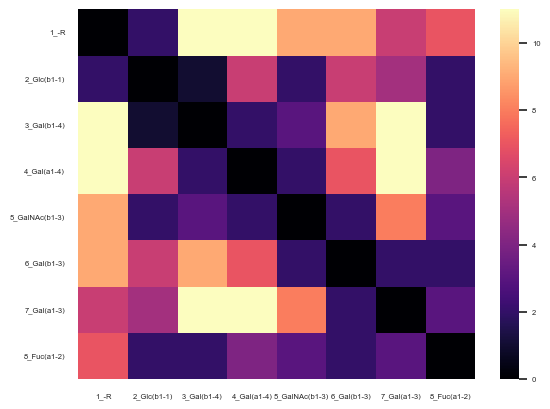

In [5]:
### On distance tables, smaller distances are darker. 
### Here, two darker squares indicate a close proximity between monosaccharides 3 (Gal(b1-4)), 5 (GalNAc(b1-3)), and 8 (Fuc(a1-2)), despite the distance separating them in sequence.
draw_contact_map(dist_table)

In [6]:
plot_glycan_3D(g)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

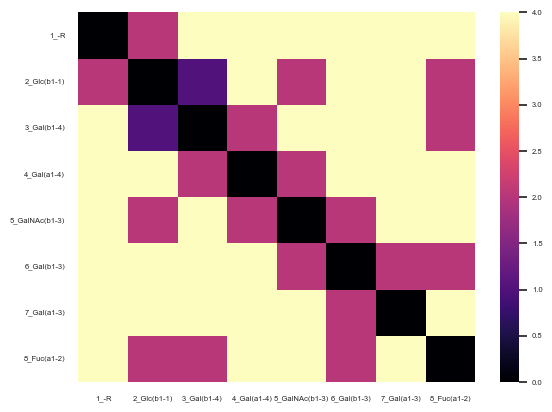

In [7]:
### With a map limited to very close interactions, we can only see binary covalent linkages
draw_contact_map(dist_table_closer)

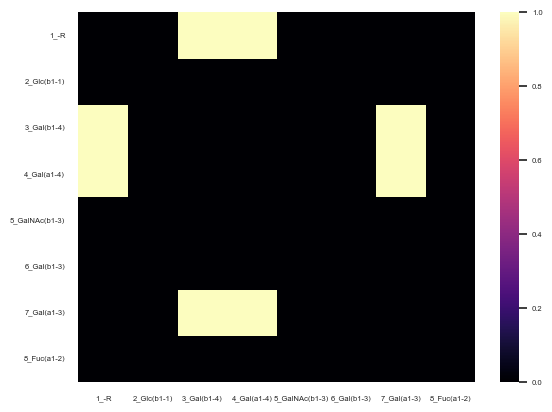

In [8]:
### The binary contact map is just a simplified fingerprint of the interactions, according to a given distance threshold
draw_contact_map(binary_table)

Following the same principle, one can generate atomic distance maps

In [9]:
### The 'exclusive' mode allows to exclude interactions between atoms from the same monosaccharide
dist_table = make_atom_contact_table(df,mode='exclusive')

### Alternatively, it is also possible to display all atomic interactions
inclusive_dist_table = make_atom_contact_table(df,mode='inclusive')

### Setting a very high-threshold allows to visualize all interatomic relations
all_inclusive_dist_table = make_atom_contact_table(df,mode='inclusive', threshold = 200)

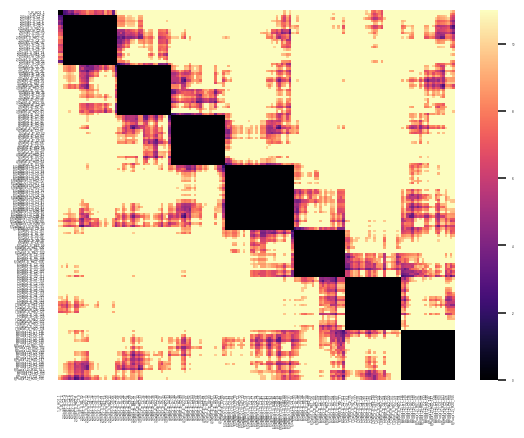

In [10]:
draw_contact_map(dist_table,size = 0.2)

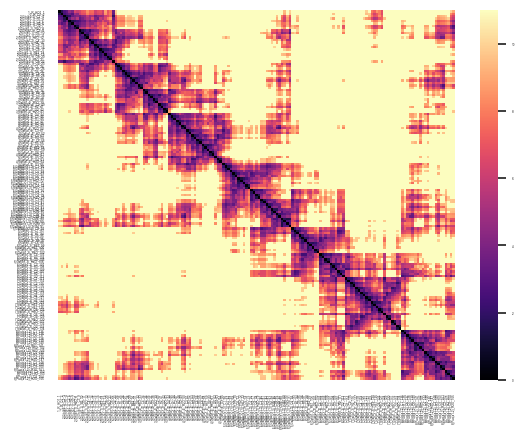

In [11]:
draw_contact_map(inclusive_dist_table,size = 0.2)

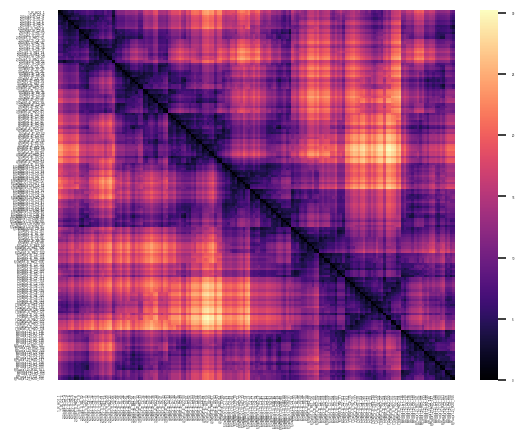

In [12]:
draw_contact_map(all_inclusive_dist_table,size = 0.2)

### 4.2 Contact frequencies

Given a distance threshold, one can count how often a pair of monosaccharides is in "contact" (below the threshold) across the different PDB files. 

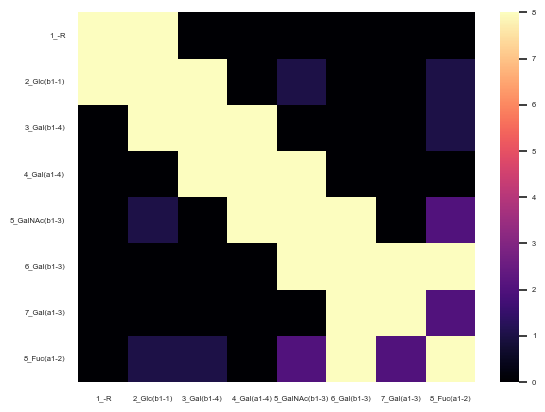

In [13]:
### Computation and display of contact frequencies according to a given threshold of 3Å
isft = inter_structure_frequency_table(g, stereo = 'beta', threshold = 3)
draw_contact_map(isft)

### 4.3 Structural flexibility

Structural flexibility is determined by how a given residue moves relatively to all other monosaccharides across multiple PDB files. 

Three methods can be specified to determine monosaccharide/atom flexibility across structural clusters.

Method 1:<br>
For each pair of entities pE (monosaccharide or atom) in each structure S, the average distance D is computed as follows:<br><br>
D(pE) = (D(pE_S1) + D(pE_S2) + ... + D(pE_Sn)) / n<br><br>
Where:<br>
pE is a pair of entities (monosaccharide or atom),<br>
D(pE_Si) is the distance between the pair of entities in the i-th structure, n is the total number of structures.<br><br>
Then, the flexibility score F for the pair of entities pE is computed as follows:<br><br>
F(pE) = SUM(|D(pE_S1) - D(pE)|, |D(pE_S2) - D(pE)|, ..., |D(pE_Sn) - D(pE)|)<br><br>
Where:<br>
F(pE) is the instability score for the pair of entities pE,<br>
SUM is the sum of all absolute differences between the distance of the pair of entities in each structure and the average distance.<br><br><br>
Method 2 (amplify):<br>
The second method is similar to the first one, but in the last step, the power of 2 of the flexibility score is used instead.<br><br><br>
Method 3 (weighted):<br>
The last method uses cluster frequencies to correct flexibility scores.

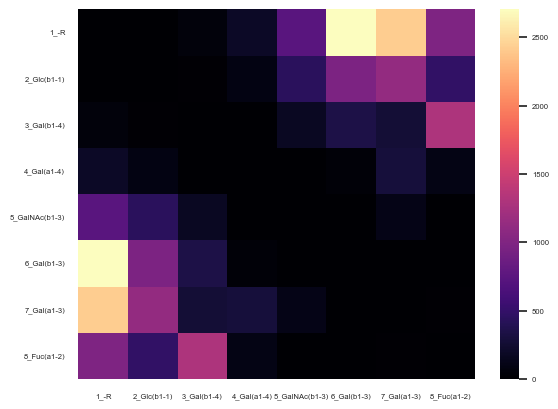

In [14]:
### Here, the amplify mode is used to highlight monosaccharide pairs distance variability
isvt = inter_structure_variability_table(g, stereo = 'beta', mode = 'amplify')
draw_contact_map(isvt)

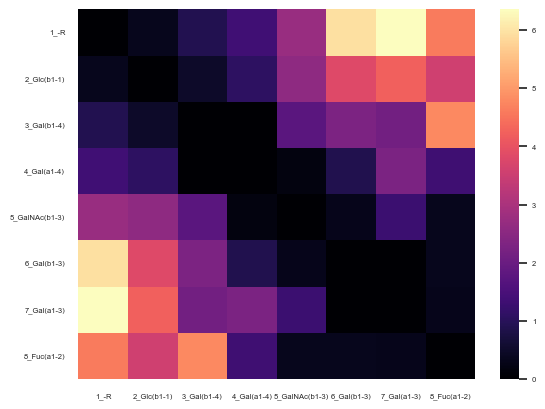

In [15]:
### With the weighted mode:
isvt = inter_structure_variability_table(g, stereo = 'beta', mode = 'weighted')
draw_contact_map(isvt)

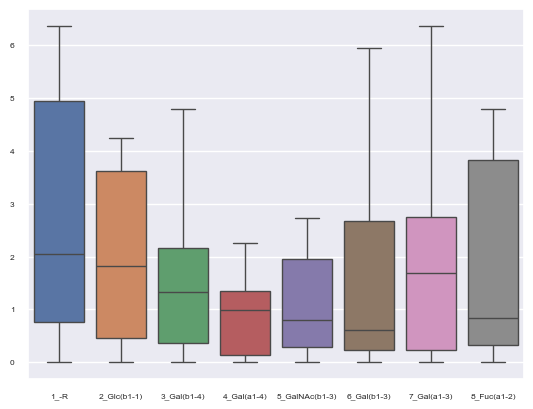

In [16]:
### Monosaccharide flexibility can also be visualized through seaborn boxplots
p = sns.boxplot(isvt)
p.tick_params(labelsize=6)
plt.show()

The overall flexibility of each monosaccharide can be computed as a sum or a mean of the flexibility of all pairs of interactions involving this residue. 

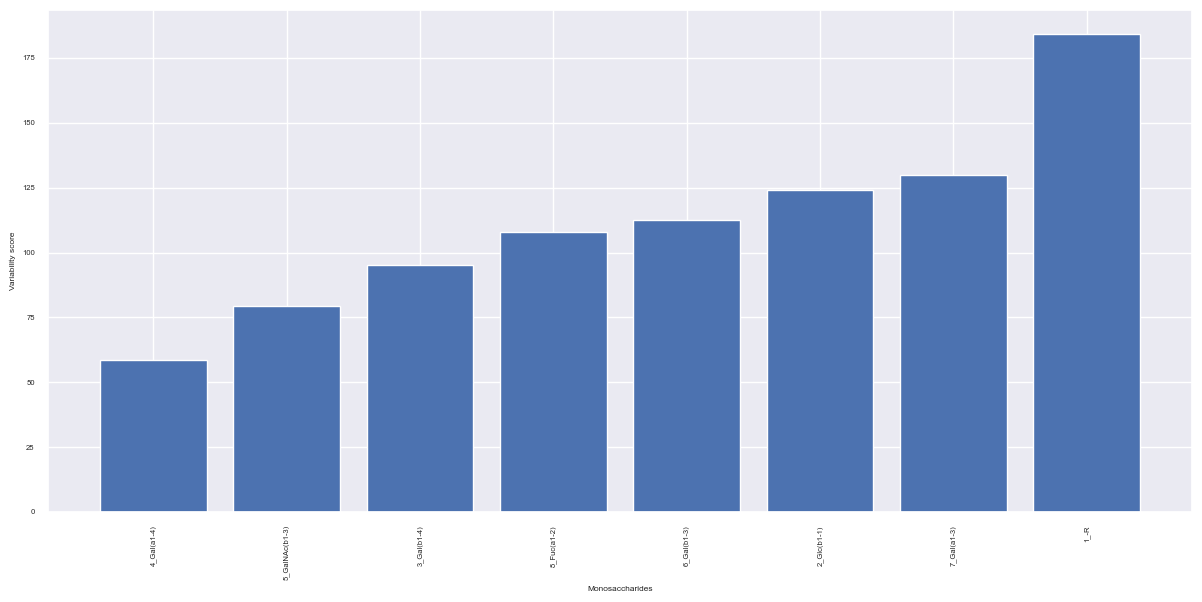

In [17]:
### Two possibilities: mean or sum
plot_monosaccharide_instability(g, mode='sum')

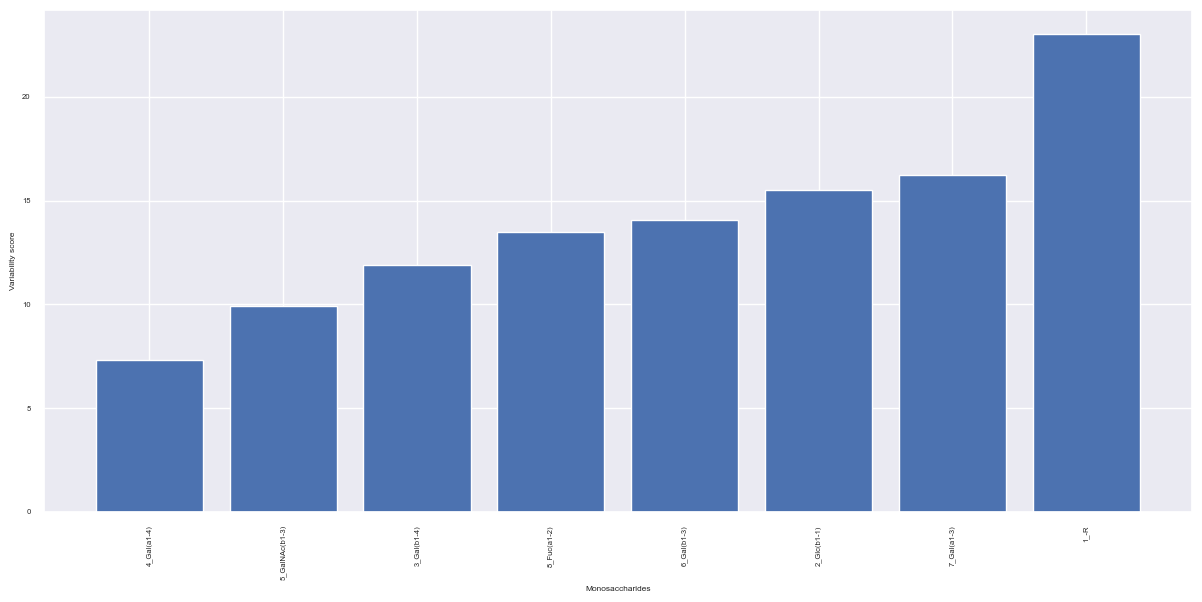

In [18]:
### Mean
plot_monosaccharide_instability(g, mode='mean')

### 4.4 Structural co-variability

Using Pearson correlation, one can compute and display a correlation matrix

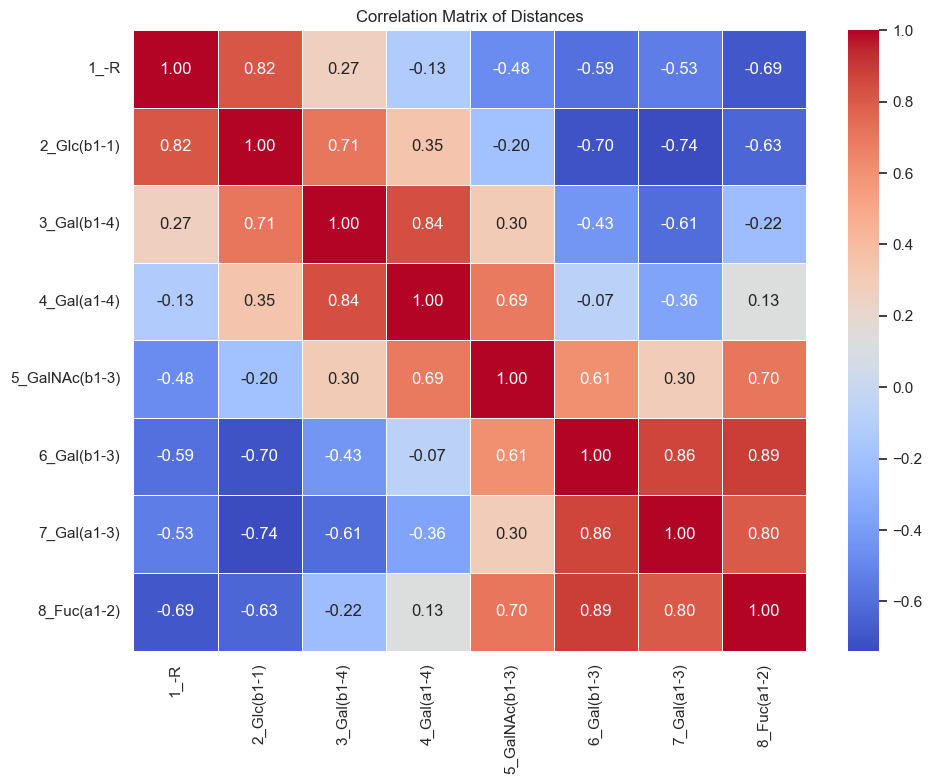

In [19]:
mx = make_correlation_matrix(g, stereo = 'beta')
show_correlations(mx)

### High positive values (red) mean correlations
### 0 (white) means no correlation
### Low negative values (blue) mean anti-correlations
### Here, we see a strong anti-correlation between the root (residues 1 and 2) and the terminal residues 6, 7 and 8, suggesting a repulsion or structural constraints
### We also see a correlation between Fucose (residue 8) and GalNAc (residue 5), suggesting a mutual influence 

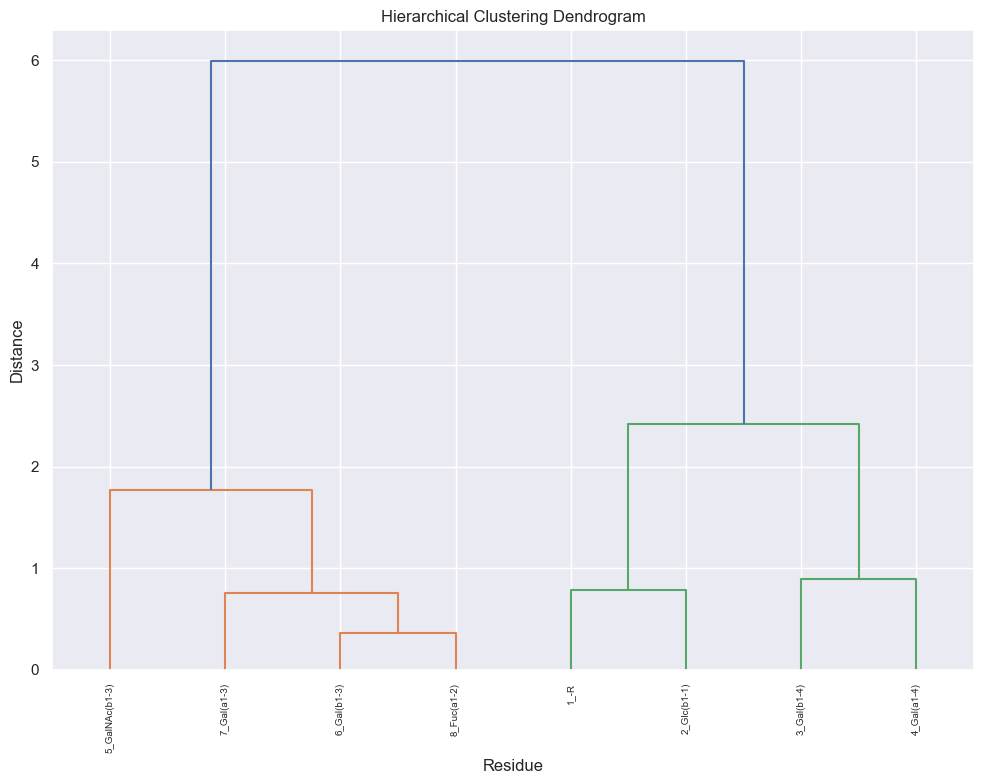

{'C2': ['1_-R', '2_Glc(b1-1)', '3_Gal(b1-4)', '4_Gal(a1-4)'],
 'C1': ['5_GalNAc(b1-3)', '7_Gal(a1-3)', '6_Gal(b1-3)', '8_Fuc(a1-2)']}

In [20]:
### Monosaccharides can be plotted on a dendrogram based on their correlation
show_correlation_dendrogram(mx, font_size = 7)

### 4.5 Solvent Accessible Surface Area (SASA)

In 3D structures, residues can either be buried or exposed to the solvent. The SASA score allows to determine if a residue is rather exposed or hidden, which means a lot to predict interactions with other molecular partners.

In [21]:
### With a given glycan and linkage type, we can directly return a dataframe indicating the mean, median and weighted SASA scores.
get_sasa_table(g, stereo = 'beta')

### Here, fucose (residue nb 8) is particularly interesting. According to the IUPAC sequence, Fuc is, with Gal(a1-3), a terminal residue.
### However, despite such position in the sequence, its SASA score is much lower than Gal(a1-3), meaning that it is less exposed.
### This is consistent with the previous finding that Fuc is interacting with residues 3 and 5, sticking to other monosaccharides rather than being exposed to the surface.



,Monosaccharide_id,Monosaccharide,SASA,Standard Deviation,Coefficient of Variation
0,1,-R,0.489343,0.035817,0.073889
1,2,Glc(b1-1),1.942360,0.316070,0.158366
2,3,Gal(b1-4),1.686128,0.177812,0.105599
3,4,Gal(a1-4),1.704267,0.081855,0.047993
4,5,GalNAc(b1-3),1.978930,0.173324,0.090403
5,6,Gal(b1-3),1.489639,0.068911,0.046056
6,7,Gal(a1-3),2.380684,0.094028,0.039305
7,8,Fuc(a1-2),1.574338,0.225500,0.138969


Using GlycoDraw, it is possible to represent a glycan and highlight its monosaccharides according to a list of scores. Let see how it works with weighted SASA scores

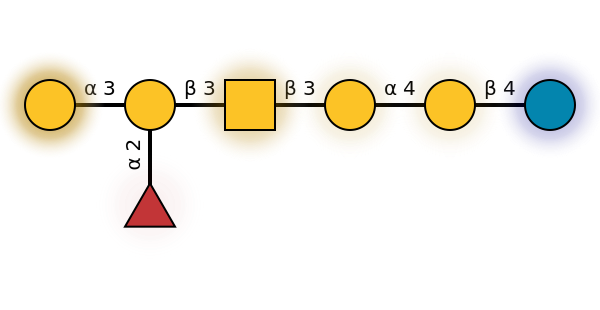

In [22]:
plot_glycan_score(g)

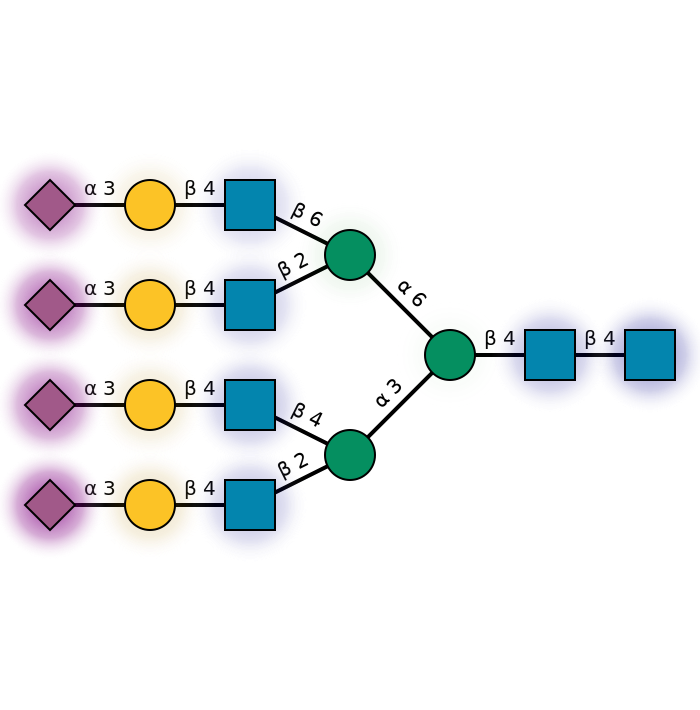

In [23]:
glycan = 'Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc'
plot_glycan_score(glycan)